In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from peewee import *
from datetime import date, datetime
import matplotlib.dates as mdates
import re

In [81]:
db = MySQLDatabase('airfares', user='root', password='toor', host='localhost', autocommit=True)

In [82]:
class Flight(Model):
    flightKey = CharField(max_length=255, unique=True, index=True)
    flightNumber = CharField(max_length=50)
    departureDate = DateField()
    arrivalDate = DateField()
    departureTime = TimeField()
    arrivalTime = TimeField()
    journeyDuration = TimeField()
    totalNumberOfStops = IntegerField()
    carrierCode = CharField(max_length=50)
    depAirportCode = CharField(max_length=50)
    arrAirportCode = CharField(max_length=50)

    class Meta:
        database = db

class Price(Model):
    priceID = AutoField()
    flightKey = ForeignKeyField(Flight, to_field='flightKey', on_delete='CASCADE', on_update='CASCADE')
    scrapeDate = DateField()
    availableSeats = IntegerField()
    adultPrice = FloatField()

    class Meta:
        database = db

class Airport(Model):
    airportCode = CharField(max_length=50, unique=True, index=True)
    airportName = CharField(max_length=255)
    city = CharField(max_length=255)
    country = CharField(max_length=255)

    class Meta:
        database = db

class Airline(Model):
    carrierCode = CharField(max_length=50, unique=True, index=True)
    carrierName = CharField(max_length=255)

    class Meta:
        database = db

In [83]:
db.connect()
query1 = Flight.select().dicts()
query2 = Price.select().dicts()
query3 = Airport.select().dicts()
query4 = Airline.select().dicts()

flight_data = list(query1)
price_data = list(query2)
airport_data = list(query3)
airline_data = list(query4)

df_flight = pd.DataFrame(flight_data)
df_price = pd.DataFrame(price_data)
df_airport = pd.DataFrame(airport_data)
df_airline = pd.DataFrame(airline_data)
db.close()

True

In [84]:
df_price

,priceID,flightKey,scrapeDate,availableSeats,adultPrice
0,1,TB_OST_ALC_2023-04-09_TB1183,2023-04-07,5,149.99
1,2,TB_BRU_ALC_2023-04-09_TB1111,2023-04-07,-1,129.99
2,3,TB_ANR_ALC_2023-04-09_TB1101,2023-04-07,9,99.99
3,4,TB_ANR_ALC_2023-04-09_TB1103,2023-04-07,9,129.99
4,5,TB_ANR_ALC_2023-04-09_TB1105,2023-04-07,-1,99.99
...,...,...,...,...,...
66504,66505,HV_BRU_TFS_2023-09-16_HV9061,2023-04-19,10,154.00
66505,66506,HV_BRU_TFS_2023-09-20_HV9061,2023-04-19,-1,154.00
66506,66507,HV_BRU_TFS_2023-09-23_HV9061,2023-04-19,8,170.00
66507,66508,HV_BRU_TFS_2023-09-27_HV9061,2023-04-19,4,185.00


### (1) Welke vliegtuigmaatschappij is gemiddeld de goedkoopste / de duurste?

##### Ryanair

In [85]:
ryanair_mean_price = df_price[df_price['flightKey'].isin(df_flight[df_flight['carrierCode'] == 'FR']['flightKey'])]['adultPrice'].mean()

##### Tui

In [86]:
tui_mean_price = df_price[df_price['flightKey'].isin(df_flight[df_flight['carrierCode'] == 'TB']['flightKey'])]['adultPrice'].median()

##### Transavia

In [87]:
transavia_mean_price = df_price[df_price['flightKey'].isin(df_flight[df_flight['carrierCode'] == 'HV']['flightKey'])]['adultPrice'].median()

<BarContainer object of 3 artists>

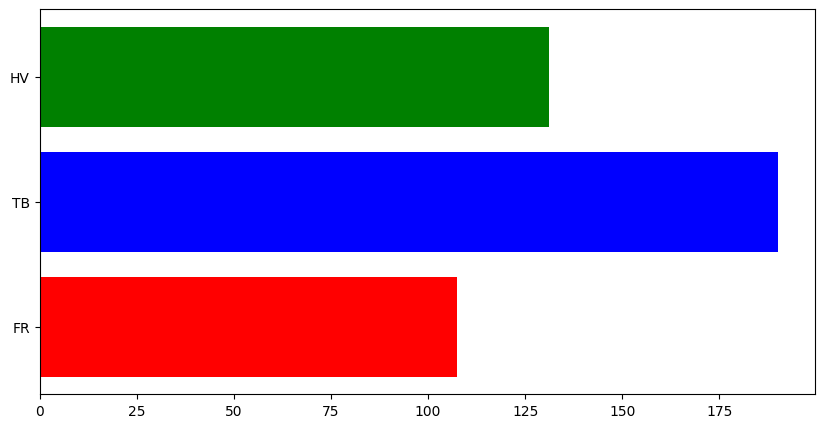

In [88]:
plt.figure(figsize=(10, 5))

carrier_codes = ['FR', 'TB', 'HV']
carrier_names = ['Ryanair', 'TUI', 'Transavia']

carrier_mean_prices = [ryanair_mean_price, tui_mean_price, transavia_mean_price]

colors = ['red', 'blue', 'green']

plt.barh(carrier_codes, carrier_mean_prices, color=colors)

### (8) Zijn de prijzen gerelateerd aan vakantieperiodes hier of ter plaatse?

In [89]:
vakantieperiodes_belgie = {
    'krokusvakantie': ['2023-02-20', '2023-02-26'], 
    'paasvakantie': ['2023-04-01', '2023-04-15'], 
    'zomervakantie': ['2023-07-01', '2023-08-31'], 
    'herfstvakantie': ['2023-10-18', '2023-10-25'], 
    'kerstvakantie': ['2023-12-19', '2024-01-03']
}

### (9) Kan je de prijsstrategie afleiden? (Invloed van aantal dagen voor vertrek, invloed van beschikbaarheid)

TB_BRU_ALC_2023-04-09_TB1111
Departure Date: 2023-04-09


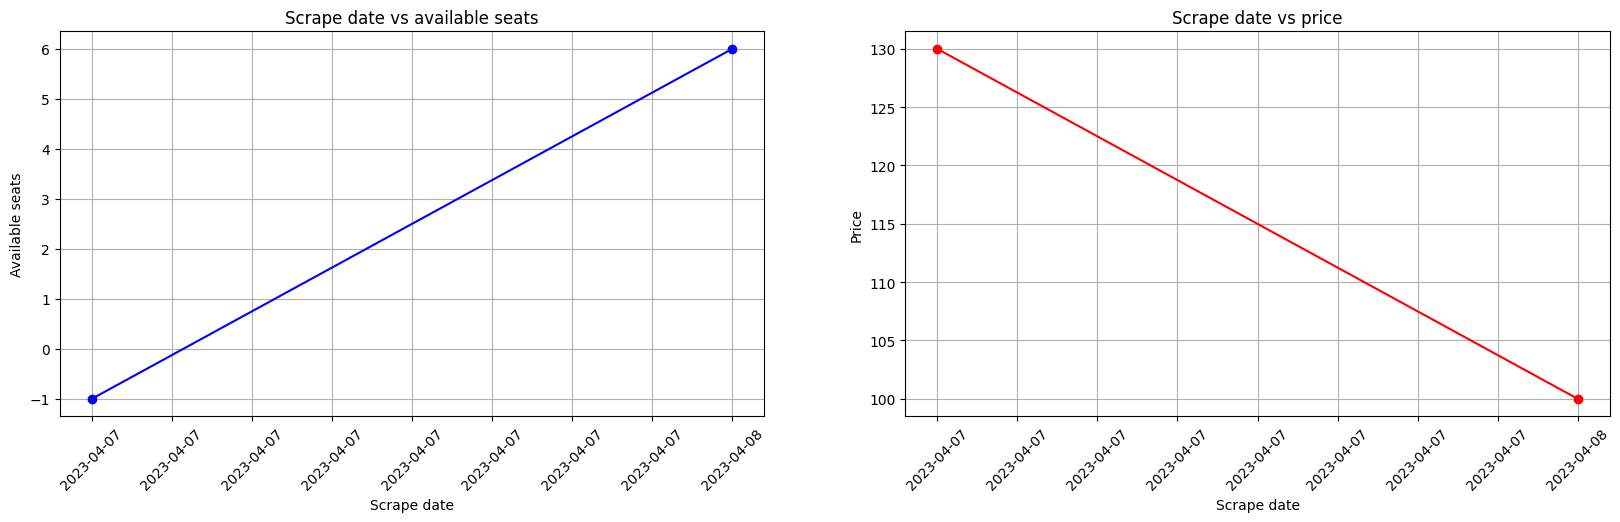

TB_ANR_ALC_2023-04-09_TB1101
Departure Date: 2023-04-09


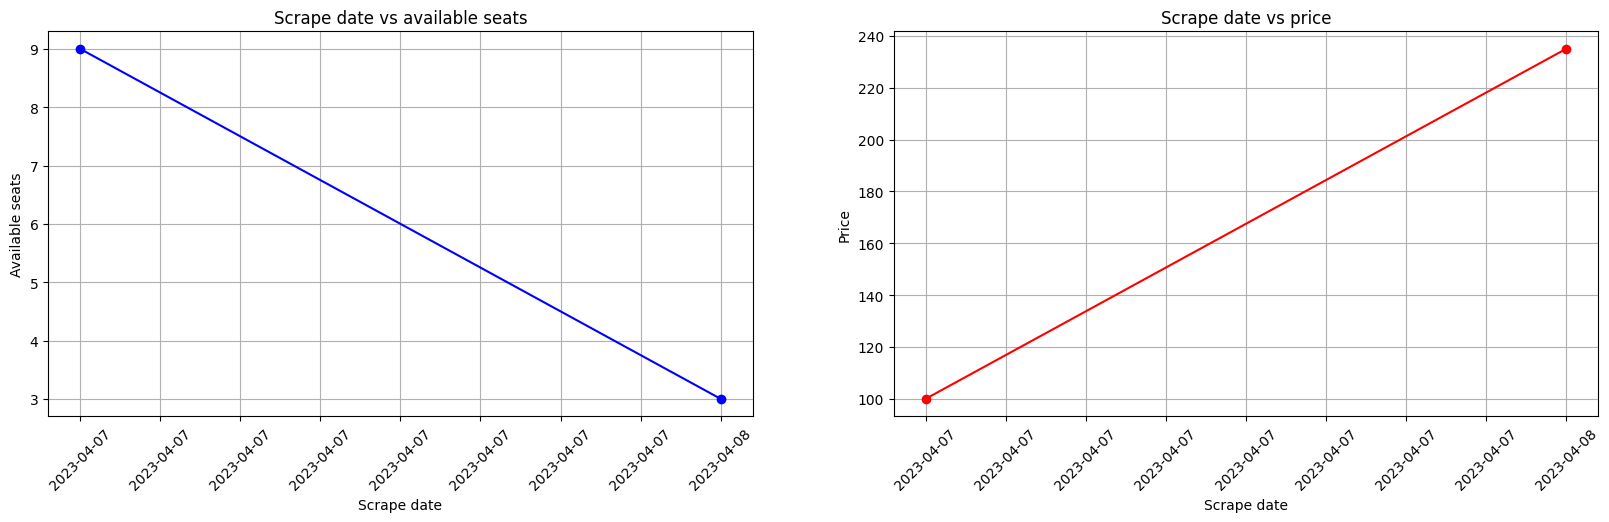

TB_ANR_ALC_2023-04-09_TB1103
Departure Date: 2023-04-09


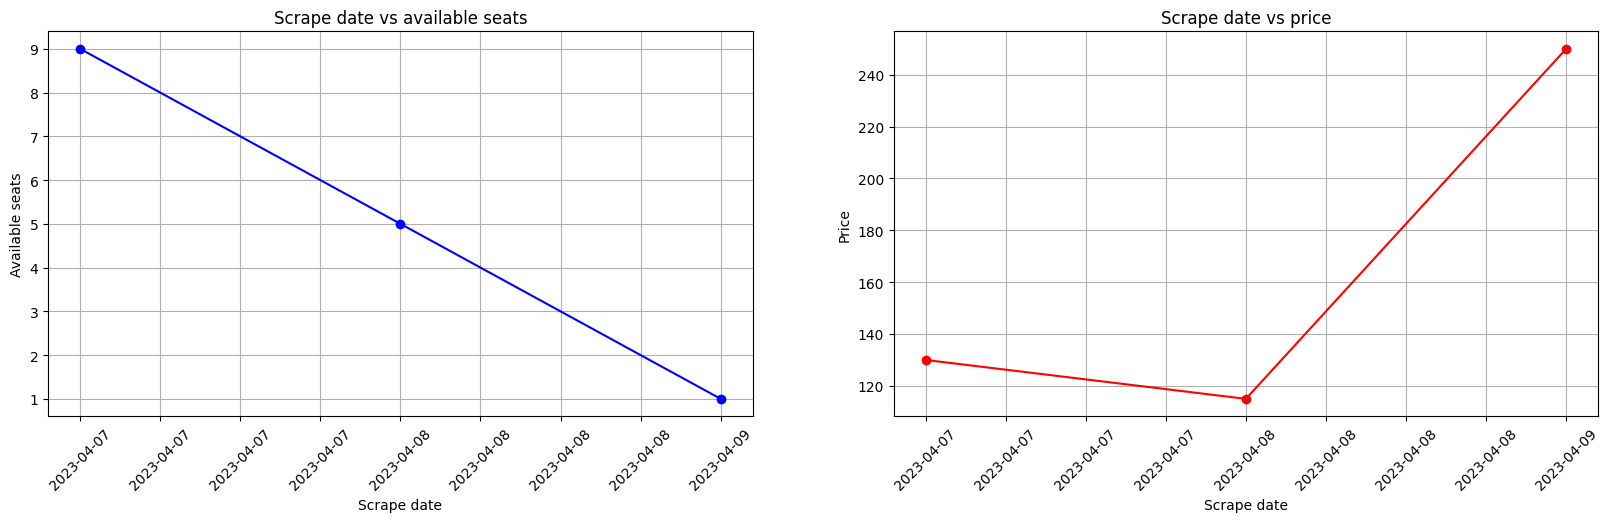

TB_ANR_ALC_2023-04-09_TB1105
Departure Date: 2023-04-09


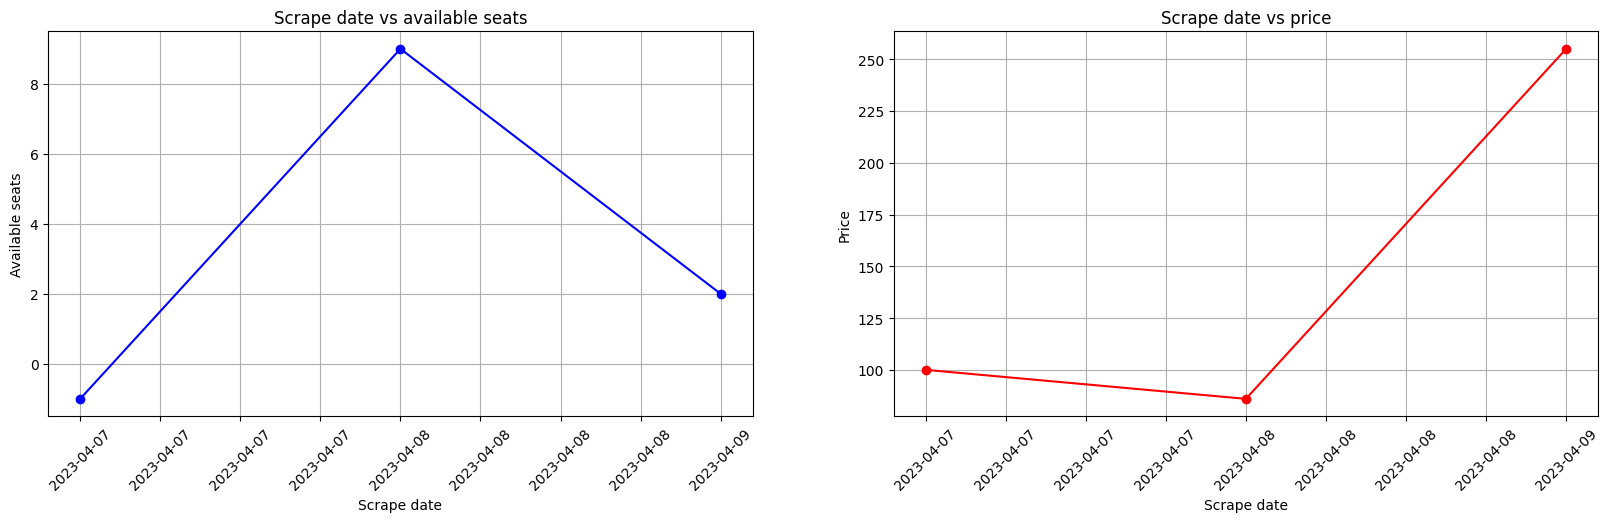

TB_BRU_ALC_2023-04-09_TB1113
Departure Date: 2023-04-09


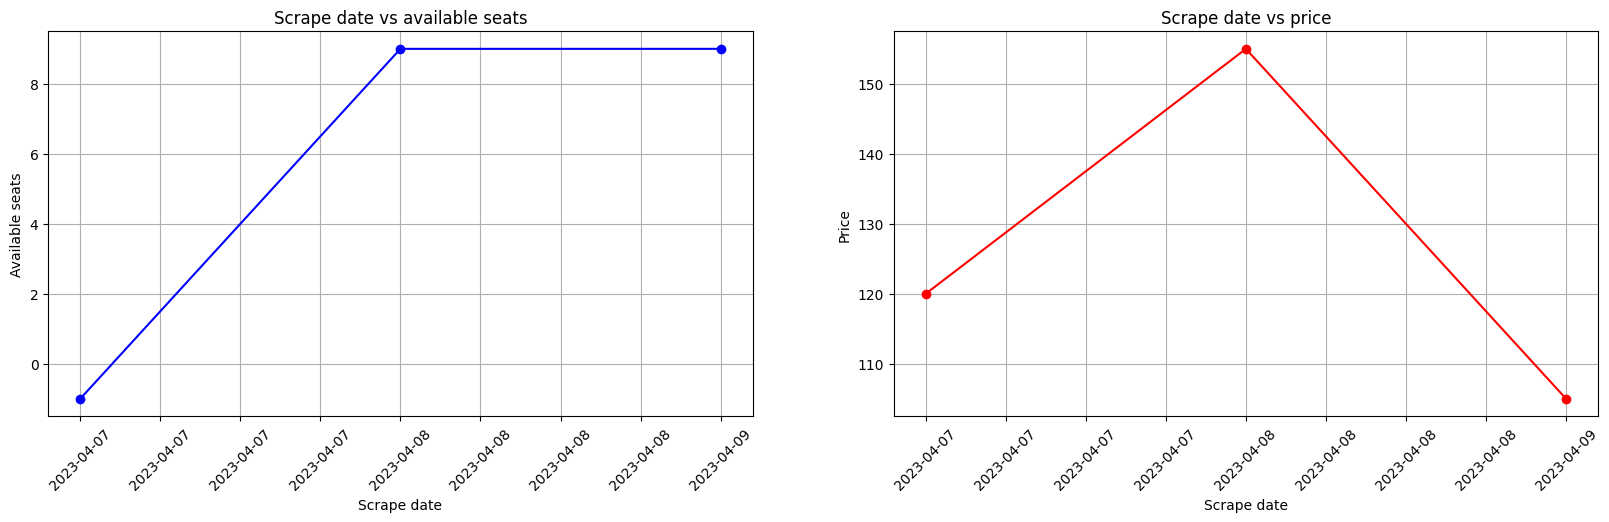

TB_LGG_ALC_2023-04-10_TB1161
Departure Date: 2023-04-10


KeyboardInterrupt: 

In [90]:
def get_flight_data(flight_key):
    flight_data = df_price[df_price['flightKey'] == flight_key]
    flight_data = flight_data.loc[:, ['scrapeDate', 'adultPrice', 'availableSeats']]
    dep_date = get_dep_date_from_key(flight_key)
    flight_data['departureDate'] = dep_date
    flight_data = flight_data.sort_values(by=['scrapeDate', 'departureDate'])
    return flight_data

def get_dep_date_from_key(flight_key):
    date_pattern = r'\d{4}-\d{2}-\d{2}'
    match = re.search(date_pattern, flight_key)
    if match:
        date = match.group()
        return date

unique_flight_keys = df_price['flightKey'].unique()

for i in unique_flight_keys:
    df = get_flight_data(i)
    df = df.sort_values(by=['departureDate', 'scrapeDate'])
    df = df.reset_index(drop=True)
    df = df.set_index('departureDate')
    df['scrapeDate'] = pd.to_datetime(df['scrapeDate'])

    if len(df) > 1 and (df['availableSeats'] != -1).any():

        print(i)

        for j in df.index.unique():

            print(f"Departure Date: {j}")

            fig, ax = plt.subplots(1, 2, figsize=(20, 5))

            ax[0].plot_date(df.loc[j]['scrapeDate'], df.loc[j]['availableSeats'], color='blue', linestyle='solid')
            ax[0].set_xlabel('Scrape date')
            ax[0].tick_params(axis='x', rotation=45)
            date_fmt = mdates.DateFormatter('%Y-%m-%d')
            ax[0].xaxis.set_major_formatter(date_fmt)
            ax[0].set_ylabel('Available seats')
            ax[0].set_title(f'Scrape date vs available seats')
            ax[0].grid()

            ax[1].plot_date(df.loc[j]['scrapeDate'], df.loc[j]['adultPrice'], color='red', linestyle='solid')
            ax[1].set_xlabel('Scrape date')
            ax[1].tick_params(axis='x', rotation=45)
            ax[1].xaxis.set_major_formatter(date_fmt)
            ax[1].set_ylabel('Price')
            ax[1].set_title(f'Scrape date vs price')
            ax[1].grid()

            plt.show()